In [1]:
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

fr_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.fr.vec")
en_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.en.vec")


from gensim.models import KeyedVectors
import numpy as np

ar_embeddings = KeyedVectors.load_word2vec_format("wiki.multi.ar.vec", limit=50000)

# Pad the vectors with zeros to match the desired dimensionality (300 in this case)
vector_size = 300
new_vectors = np.zeros((len(ar_embeddings.key_to_index), vector_size))
for word, idx in ar_embeddings.key_to_index.items():
    if len(ar_embeddings.get_vector(word)) == vector_size:
        new_vectors[idx] = ar_embeddings.get_vector(word)
    else:
        print(f"Skipping word '{word}' with vector size {len(ar_embeddings.get_vector(word))}")
ar_embeddings.vectors = new_vectors
ar_embeddings.vector_size = vector_size

In [2]:
import nltk
import numpy as np
from wordfreq import word_frequency
from sklearn.decomposition import TruncatedSVD


def compute_sentence_embeddings(questions, word_embeddings, language, a=0.001): 
    
    question_embeddings = []
    for question in questions: 
        tokens = [t.lower() for t in nltk.word_tokenize(question)]
        tokens = [token for token in tokens if token in word_embeddings]

        weights = [a/(a+word_frequency(token, language)) for token in tokens]
        embedding = np.average([word_embeddings[token] for token in tokens], axis=0, weights=weights)
        question_embeddings.append(embedding)
        
    return question_embeddings

## SVM Linear - Fine Tunning before testing on Arabic

In [3]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM with RBF kernel on the training set
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.824
              precision    recall  f1-score   support

    negative       0.82      0.83      0.82      4961
    positive       0.83      0.82      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



[[4113  848]
 [ 912 4127]]


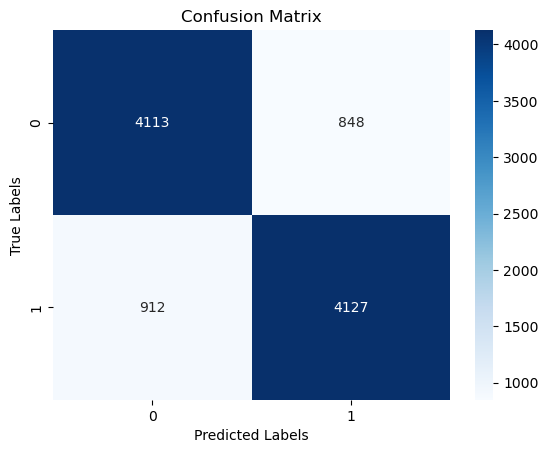

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [5]:
import joblib
joblib.dump(svm, 'SVM_linear_beforeFineTuning_multilingual_Report.pkl')

['SVM_linear_beforeFineTuning_multilingual_Report.pkl']

In [6]:
svm = joblib.load('SVM_linear_beforeFineTuning_multilingual_Report.pkl')

# Test on Arabic before Fine Tune

In [7]:
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:50000]
print(df.shape)

# Select the next 500 rows of the dataset
df2 = df_.iloc[50000:100000]
# print(df1.shape)
print(df2.shape)
# df.head()

(105698, 7)
(50000, 7)
(50000, 7)


In [8]:

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

df

,no,Hotel name,rating,user type,room type,nights,review,sentiment,arabic_Embeddings
0,64908,بودل الفيحاء,1,مسافر منفرد,جناح من غرفة نوم واحدة,أقمت ليلتين,“لا انصح بالسكن فيه ولن اكرر تجربتي مع بودل”. ...,negative,"[-0.053905951935531604, -0.014622465750185326,..."
1,24092,المروة ريحان من روتانا - مكة,1,أسرة,غرفة رباعية بريميوم,أقمت 5 ليالي,“ماعجبني ابدأ الفندق”. الافطارلاباس السرير مر...,negative,"[-0.024345980312994387, -0.017980983919531776,..."
2,108007,دار الفهد للشقق الفندقية,1,أسرة,-,أقمت ليلة واحدة,“أثاثها قديم ومتسخ جداً غير صالح للاستخدام”. ا...,negative,"[-0.02423540361416414, -0.028972101360596605, ..."
3,155802,جولدن توليب البرشاء,1,مسافر منفرد,غرفة قياسية,أقمت 3 ليالي,“اسواء فندق اقمت فيه”. . الخدمات و النظافة,negative,"[-0.07062224850765304, -0.020988578390386266, ..."
4,149128,فندق فورتشن بلازا,1,مسافر منفرد,غرفة ديلوكس,أقمت 3 ليالي,“اغباء فندق في العالم”. . كل شي سيئ يوجد حشرات...,negative,"[-0.023022204479338816, -0.030984906839331097,..."
...,...,...,...,...,...,...,...,...,...
9995,170783,فندق وأجنحة هوثورن من ويندهام,5,-,غرفة ديلوكس,أقمت 5 ليالي,“جميييييييل”. الوان الغرفه كبر الغرفه الخدمه ا...,positive,"[-0.039616949246513225, -0.006864479102795054,..."
9996,80161,سيتي بريميير للشقق الفندقية,5,-,شقة ديلوكس من غرفة نوم واحدة تطل على برج خليفة,أقمت ليلة واحدة,“رايق للعوايل وللشباب المحافظين”. رائع في التج...,positive,"[-0.01863947375243782, -0.026245007884989284, ..."
9997,112199,دار الهجرة إنتركونتيننتال,5,أسرة,غرفة ثلاثية مطلة على المدينة - للمدخنين,أقمت ليلتين,“رائع”. قربه من الحرم النظافة عدم الازعاج يوم ...,positive,"[-0.05853575314017067, -0.01359226692353851, -..."
9998,153730,فندق جلوريا,5,أسرة,-,أقمت ليلة واحدة,“تجربة جميلة جدير بالتجربة”. النظافة وسرعة الخ...,positive,"[-0.0176337960949005, 0.0026524817289615855, -..."


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:

svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8575
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      1012
    positive       0.90      0.81      0.85       988

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



[[919  93]
 [192 796]]


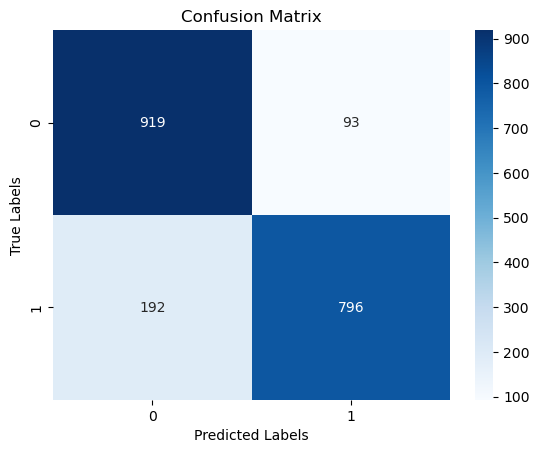

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [12]:
import joblib
joblib.dump(svm, 'SVM_linear_En_Ar_MModel.pkl')

import pickle
filename = 'SVM_linear_En_Ar_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_linear_En_Ar_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [13]:
# svm = joblib.load('SVM_linear_En_Ar_MModel.pkl')
# svm = pickle.load(open(filename, 'rb'))

## Test on Arabic after Fine Tunning

In [14]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

df

,no,Hotel name,rating,user type,room type,nights,review,sentiment,arabic_Embeddings
0,199137,فندق إنتركونتننتال الرياض,1,-,-,أقمت ليلة واحدة,“للاسف الأسعار عاليه عن الرتزكارلتون فرق كبير”...,negative,"[-0.027617355489646743, -0.027134252482051712,..."
1,223083,روعة جراند,1,-,-,أقمت 4 ليالي,ضعيف جداً. . تعامل عامل استقبال حرامي وجذاب,negative,"[-0.07297144687830402, -0.058337575685269205, ..."
2,228780,فندق مفرق أبوظبي,1,مسافر منفرد,غرفة ديلوكس - مطلة على المدينة,أقمت ليلة واحدة,“عذاب المسافر المفرق”. لا شي. التكيف تعيس جداااا,negative,"[-0.06824178535117502, -0.013386479731770167, ..."
3,220680,أبراج لو ميريديان مكة,1,أسرة,غرفة Diplomatic,أقمت ليلة واحدة,ضعيف جداً. . تجربة سيئة جدًا ..,negative,"[-0.042811420289857356, -0.052092635723308994,..."
4,368378,صن رايز للشقق الفندقية,1,أسرة,-,أقمت 3 ليالي,ضعيف جداً. . الحشراااااااااات,negative,"[-0.07198749914818887, -0.07148322895331002, -..."
...,...,...,...,...,...,...,...,...,...
9995,378713,العنوان مرسى دبي,5,مسافر منفرد,غرفة ديلوكس,أقمت ليلتين,استثنائي. الهدوء. الانترنت ضعيف,positive,"[-0.047798823616219295, -0.030668117260095527,..."
9996,259697,فندق موفنبيك برج هاجر - مكة,5,زوج,غرفة ثلاثية كلاسيكية,أقمت ليلة واحدة,“ابو مشاري”. . ارتفاع أسعار خدمات المغسلة و ال...,positive,"[-0.039156388455817696, -0.010755269566562064,..."
9997,234967,فندق مكة ماريوت,5,أسرة,غرفة مزدوجة مع إطلال,أقمت 3 ليالي,“الفخامه و الراحة”. ببساطة .. عشت الفخامه في ي...,positive,"[-0.017306516722411888, 0.002052524856261516, ..."
9998,273868,فندق ميركيور سنتر أبو ظبي,5,-,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“جيد”. جيد. لايوجد,positive,"[-0.051552900667715944, -0.04169652922187016, ..."


In [15]:
X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8649
              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      5000
    positive       0.90      0.82      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



[[4532  468]
 [ 883 4117]]


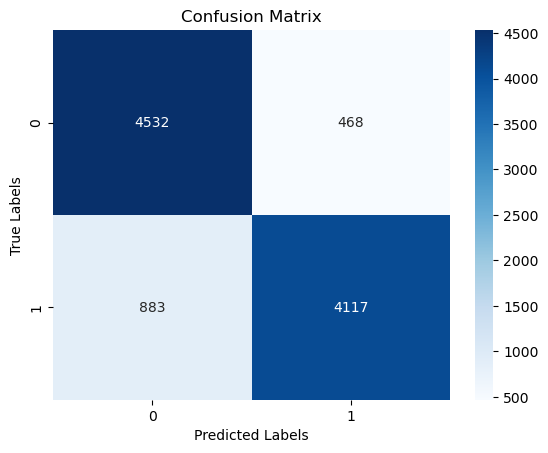

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French - FineTune - Test

In [17]:
svm = joblib.load('SVM_linear_En_Ar_MModel.pkl')
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\739881597.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.566
              precision    recall  f1-score   support

           0       0.55      0.79      0.64       250
           1       0.62      0.34      0.44       250

    accuracy                           0.57       500
   macro avg       0.58      0.57      0.54       500
weighted avg       0.58      0.57      0.54       500



[[197  53]
 [164  86]]


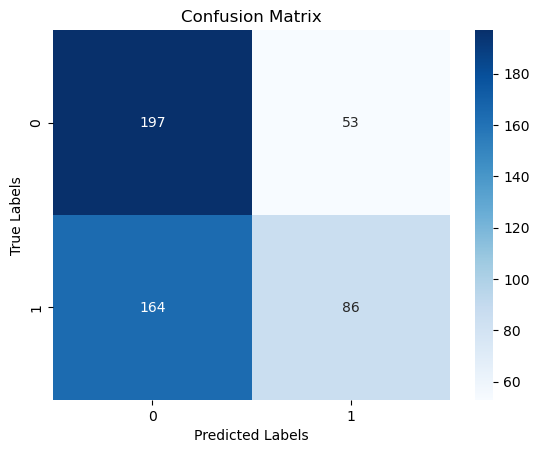

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [20]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_1 = sample.head(500)


# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_2 = sample.head(500)
# Apply sentence embeddings to first column of dataframe
reviews = final_sample_1['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_1['french_Embeddings'] = reviews_embeddings

# Apply sentence embeddings to first column of dataframe
reviews = final_sample_2['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_2['french_Embeddings'] = reviews_embeddings
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(final_sample_1['french_Embeddings']) 
y = final_sample_1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)
# from sklearn.preprocessing import LabelEncoder
# # create a LabelEncoder object
# le = LabelEncoder()

# # fit the encoder to the values and transform the values to binary values
# binary_y_pred = le.fit_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        43
           1       0.90      0.46      0.60        57

    accuracy                           0.66       100
   macro avg       0.73      0.69      0.65       100
weighted avg       0.75      0.66      0.65       100



C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\2146145837.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample_2['french_Embeddings'] = reviews_embeddings


[[40  3]
 [31 26]]


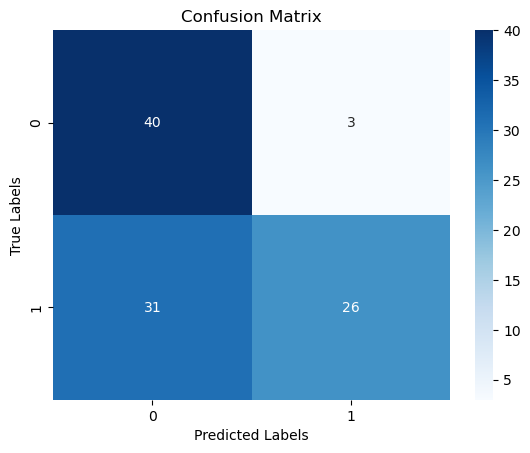

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [22]:
import joblib
joblib.dump(svm, 'SVM_linear_En_Ar_Fr_MModel.pkl')

import pickle
filename = 'SVM_linear_En_Ar_Fr_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_linear_En_Ar_Fr_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [23]:
svm = joblib.load('SVM_linear_En_Ar_Fr_MModel.pkl')

In [24]:
X_test = np.vstack(final_sample_2['french_Embeddings']) 
y_test = final_sample_2['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.678
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       250
           1       0.79      0.48      0.60       250

    accuracy                           0.68       500
   macro avg       0.71      0.68      0.67       500
weighted avg       0.71      0.68      0.67       500



[[218  32]
 [129 121]]


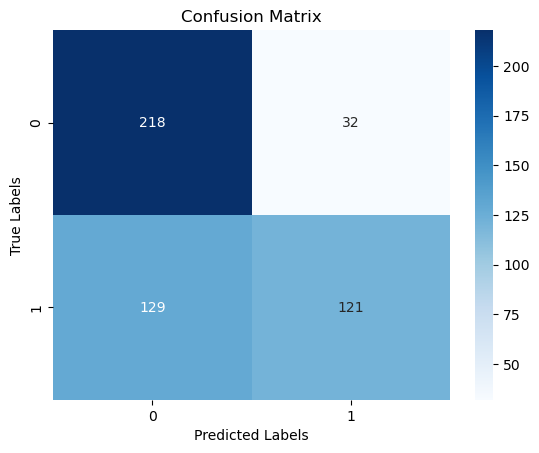

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## SVM rbf Fine Tunning

In [26]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM with RBF kernel on the training set
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8422
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.85      0.84      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4185  776]
 [ 802 4237]]


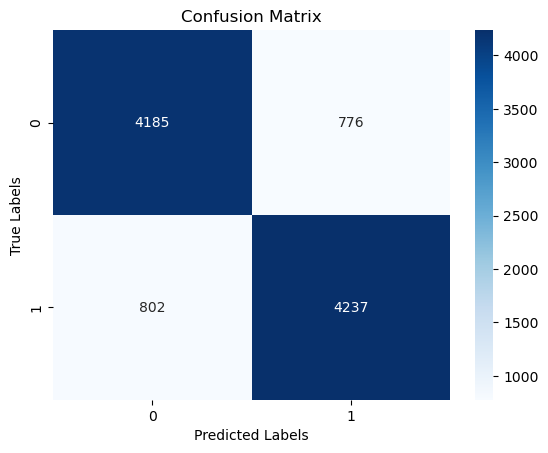

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [28]:
import joblib
joblib.dump(svm, 'SVM_rbf_beforeFineTuning_Multilingual_Report.pkl')

['SVM_rbf_beforeFineTuning_Multilingual_Report.pkl']

# Test before FineTune

In [29]:
svm = joblib.load('SVM_rbf_beforeFineTuning_Multilingual_Report.pkl')
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:50000]

# Select the next 500 rows of the dataset
df2 = df_.iloc[50000:100000]
# print(df1.shape)
print(df2.shape)
# df.head()


(105698, 7)
(50000, 7)


In [30]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.5377
              precision    recall  f1-score   support

    negative       0.86      0.09      0.16      5000
    positive       0.52      0.98      0.68      5000

    accuracy                           0.54     10000
   macro avg       0.69      0.54      0.42     10000
weighted avg       0.69      0.54      0.42     10000



[[ 452 4548]
 [  75 4925]]


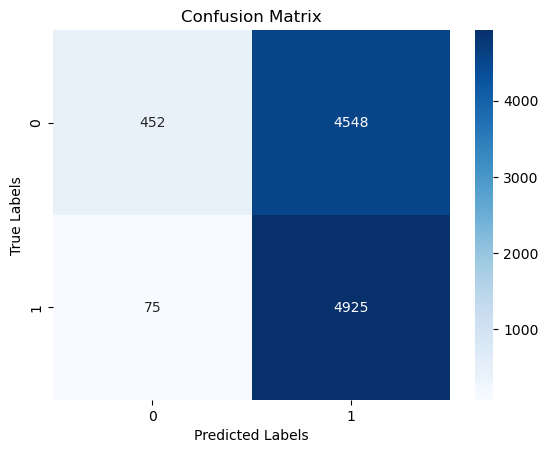

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Fine Tune

In [32]:
svm = joblib.load('SVM_rbf_beforeFineTuning_Multilingual_Report.pkl')
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 50000 rows of the dataset
df = df_.iloc[:50000]

# Select the next 500 rows of the dataset
df2 = df_.iloc[50000:100000]
# print(df1.shape)
print(df2.shape)
# df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(50000, 7)
Accuracy: 0.8685
              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1012
    positive       0.89      0.83      0.86       988

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



[[914  98]
 [165 823]]


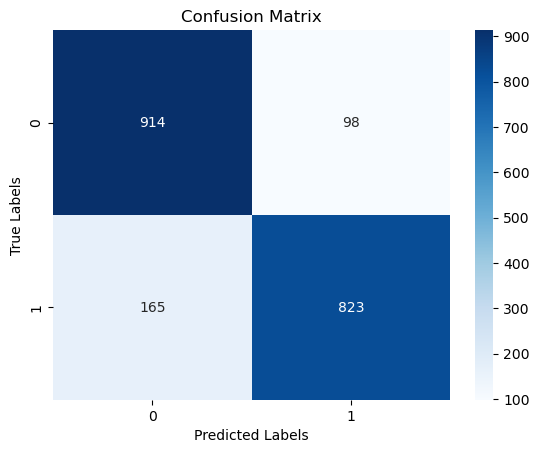

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Save Model After Fine Tune

In [34]:
import joblib
joblib.dump(svm, 'SVM_rbf_En_Ar_MModel.pkl')

import pickle
filename = 'SVM_rbf_En_Ar_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_rbf_En_Ar_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

# Test After Fine Tune

In [35]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8736
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88      5000
    positive       0.89      0.85      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



[[4480  520]
 [ 744 4256]]


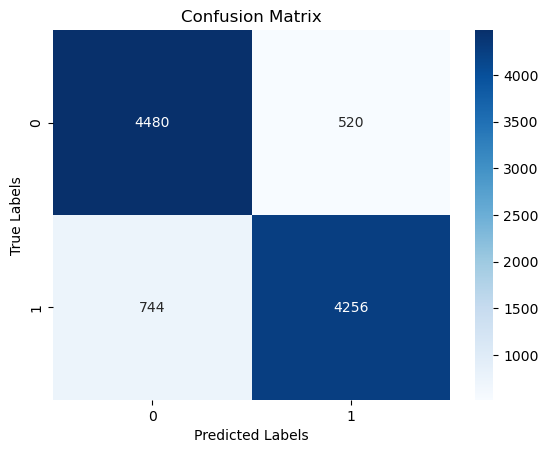

In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French - FineTune - Test

In [37]:
svm = joblib.load('SVM_rbf_En_Ar_MModel.pkl')
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\1262701966.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.56      0.79      0.65       250
           1       0.64      0.37      0.47       250

    accuracy                           0.58       500
   macro avg       0.60      0.58      0.56       500
weighted avg       0.60      0.58      0.56       500



[[198  52]
 [158  92]]


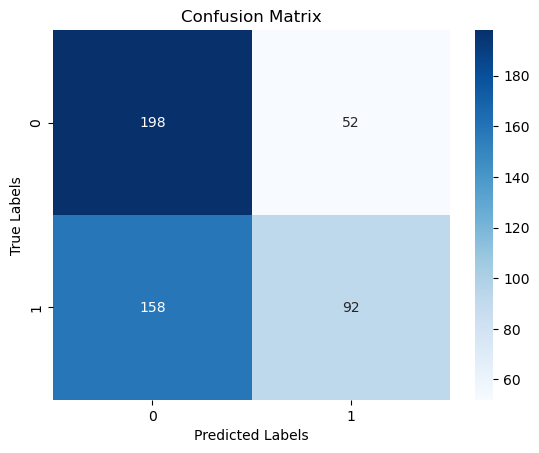

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [39]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_1 = sample.head(500)


# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_2 = sample.head(500)
# Apply sentence embeddings to first column of dataframe
reviews = final_sample_1['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_1['french_Embeddings'] = reviews_embeddings

# Apply sentence embeddings to first column of dataframe
reviews = final_sample_2['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_2['french_Embeddings'] = reviews_embeddings
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(final_sample_1['french_Embeddings']) 
y = final_sample_1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)
# from sklearn.preprocessing import LabelEncoder
# # create a LabelEncoder object
# le = LabelEncoder()

# # fit the encoder to the values and transform the values to binary values
# binary_y_pred = le.fit_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        43
           1       0.78      0.67      0.72        57

    accuracy                           0.70       100
   macro avg       0.70      0.71      0.70       100
weighted avg       0.71      0.70      0.70       100



C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\2146145837.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample_2['french_Embeddings'] = reviews_embeddings


[[32 11]
 [19 38]]


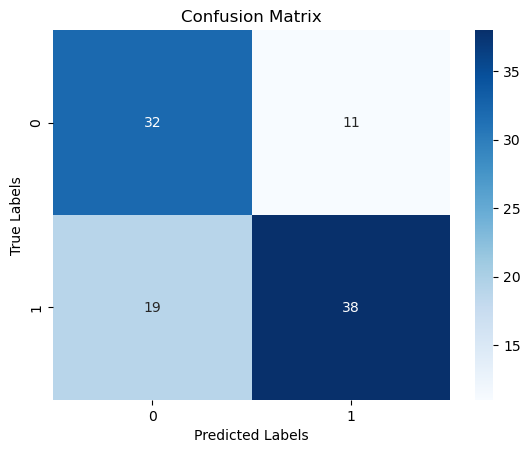

In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [41]:
import joblib
joblib.dump(svm, 'SVM_rbf_En_Ar_Fr_MModel.pkl')

import pickle
filename = 'SVM_rbf_En_Ar_Fr_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_rbf_En_Ar_Fr_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [42]:
X_test = np.vstack(final_sample_2['french_Embeddings']) 
y_test = final_sample_2['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.812
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       250
           1       0.83      0.78      0.81       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



[[211  39]
 [ 55 195]]


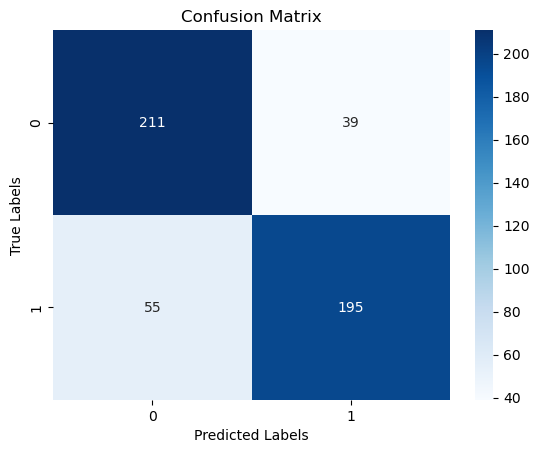

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Stand SVM rbf Fine Tunning - 

In [44]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with RBF kernel on the standardized training set
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8581
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      4961
    positive       0.86      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



[[4234  727]
 [ 692 4347]]


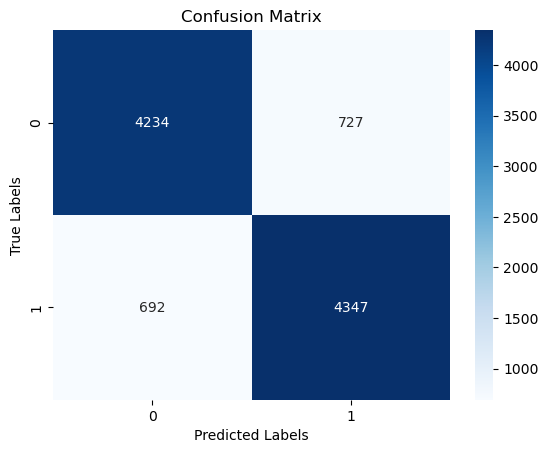

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [46]:
import joblib
joblib.dump(svm, 'SVM_rbf_Stand_beforeFineTuning_Multilingual_Report.pkl')

['SVM_rbf_Stand_beforeFineTuning_Multilingual_Report.pkl']

In [47]:
svm = joblib.load('SVM_rbf_Stand_beforeFineTuning_Multilingual_Report.pkl')
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:50000]

# Select the next 500 rows of the dataset
df2 = df_.iloc[50000:100000]
# print(df1.shape)
print(df2.shape)
# df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(50000, 7)
Accuracy: 0.8685
              precision    recall  f1-score   support

    negative       0.85      0.90      0.87      1012
    positive       0.89      0.83      0.86       988

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



[[914  98]
 [165 823]]


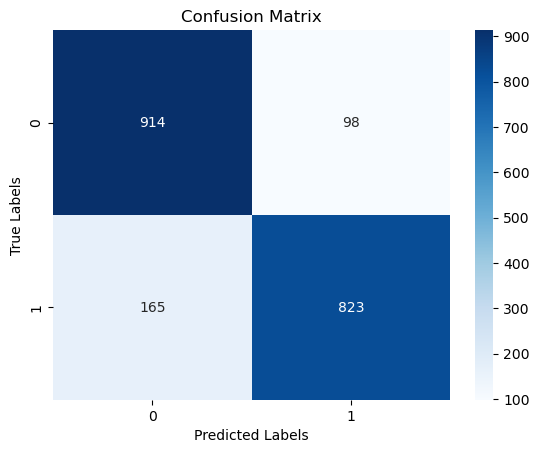

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [49]:
import joblib
joblib.dump(svm, 'SVM_S_rbf_En_Ar_MModel.pkl')

import pickle
filename = 'SVM_S_rbf_En_Ar_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_S_rbf_En_Ar_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [50]:

svm = joblib.load('SVM_S_rbf_En_Ar_MModel.pkl')

In [51]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8736
              precision    recall  f1-score   support

    negative       0.86      0.90      0.88      5000
    positive       0.89      0.85      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



[[4480  520]
 [ 744 4256]]


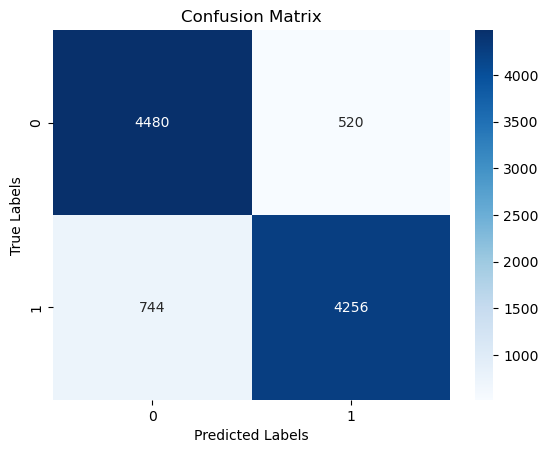

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French - FineTune - Test

In [53]:
svm = joblib.load('SVM_S_rbf_En_Ar_MModel.pkl')
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\866459638.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.58
              precision    recall  f1-score   support

           0       0.56      0.79      0.65       250
           1       0.64      0.37      0.47       250

    accuracy                           0.58       500
   macro avg       0.60      0.58      0.56       500
weighted avg       0.60      0.58      0.56       500



[[198  52]
 [158  92]]


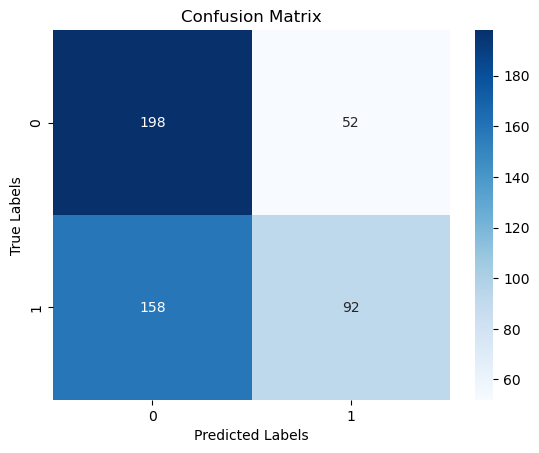

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [56]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_1 = sample.head(500)


# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_2 = sample.head(500)
# Apply sentence embeddings to first column of dataframe
reviews = final_sample_1['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_1['french_Embeddings'] = reviews_embeddings

# Apply sentence embeddings to first column of dataframe
reviews = final_sample_2['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_2['french_Embeddings'] = reviews_embeddings
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(final_sample_1['french_Embeddings']) 
y = final_sample_1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)
# from sklearn.preprocessing import LabelEncoder
# # create a LabelEncoder object
# le = LabelEncoder()

# # fit the encoder to the values and transform the values to binary values
# binary_y_pred = le.fit_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.63      0.74      0.68        43
           1       0.78      0.67      0.72        57

    accuracy                           0.70       100
   macro avg       0.70      0.71      0.70       100
weighted avg       0.71      0.70      0.70       100



C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\2146145837.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample_2['french_Embeddings'] = reviews_embeddings


[[32 11]
 [19 38]]


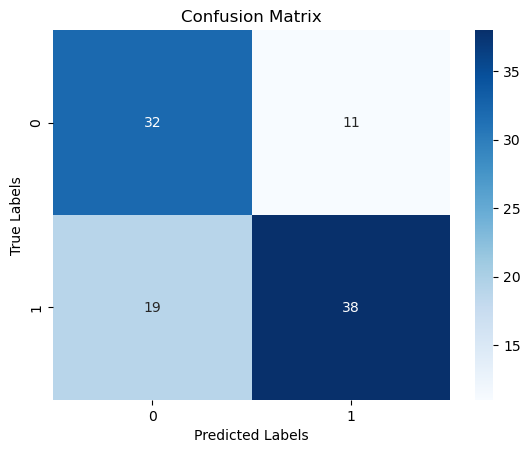

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [58]:
import joblib
joblib.dump(svm, 'SVM_S_rbf_En_Ar_Fr_MModel.pkl')

import pickle
filename = 'SVM_S_rbf_En_Ar_Fr_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_linear_En_Ar_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [59]:
svm = joblib.load('SVM_S_rbf_En_Ar_Fr_MModel.pkl')

In [60]:
X_test = np.vstack(final_sample_2['french_Embeddings']) 
y_test = final_sample_2['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.812
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       250
           1       0.83      0.78      0.81       250

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



[[211  39]
 [ 55 195]]


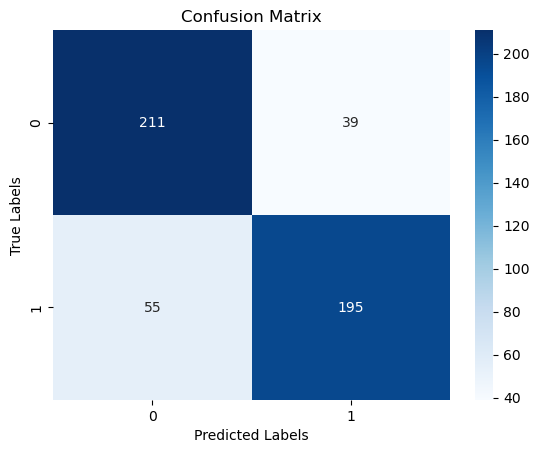

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

## Stand SVM linear - Fine Tunning before Testing on Arabic

In [62]:
import pandas as pd

# Read the CSV file into a DataFrame object
df = pd.read_csv('/Users/ALI/Desktop/IMDB Dataset.csv')

# Print the first 5 rows of the DataFrame
print(df.head(5))
reviews_all_en_emb = compute_sentence_embeddings(df['review'], en_embeddings, "en")
# Apply sentence embeddings to first column of dataframe
reviews = df.iloc[:, 0].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, en_embeddings, "en")

# Add new column with embeddings to dataframe
df['English_Embeddings'] = reviews_embeddings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Separate the input features (sentence embeddings) and output labels (sentiment)
X = np.vstack(df["English_Embeddings"])  # input features (sentence embeddings)
y = df["sentiment"]  # output labels (sentiment)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features using a scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM with linear kernel on the standardized training set
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the standardized testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Accuracy: 0.8442
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      4961
    positive       0.85      0.84      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



[[4187  774]
 [ 784 4255]]


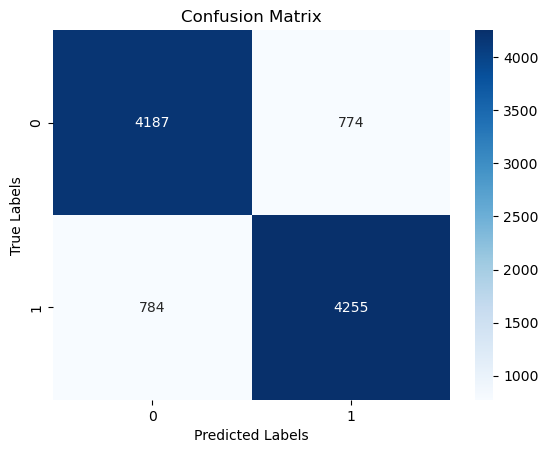

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [64]:
import joblib
joblib.dump(svm, 'SVM_Stand_linear_beforeFineTuning_Multilingual.pkl')

['SVM_Stand_linear_beforeFineTuning_Multilingual.pkl']

In [65]:
svm = joblib.load('SVM_Stand_linear_beforeFineTuning_Multilingual.pkl')
df_ = pd.read_excel('../../base-line/balanced-reviews.xlsx')
print(df_.shape)
# df = df.head(500)
# Select the first 500 rows of the dataset
df = df_.iloc[:50000]

# Select the next 500 rows of the dataset
df2 = df_.iloc[50000:100000]
# print(df1.shape)
print(df2.shape)
# df.head()

# determine the minimum number of rows for each rating value
min_count = df["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df[df["rating"] == 1]
df_2 = df[df["rating"] == 2]
df_4 = df[df["rating"] == 4]
df_5 = df[df["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(df['arabic_Embeddings']) 
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

(105698, 7)
(50000, 7)
Accuracy: 0.8575
              precision    recall  f1-score   support

    negative       0.83      0.91      0.87      1012
    positive       0.90      0.81      0.85       988

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



[[919  93]
 [192 796]]


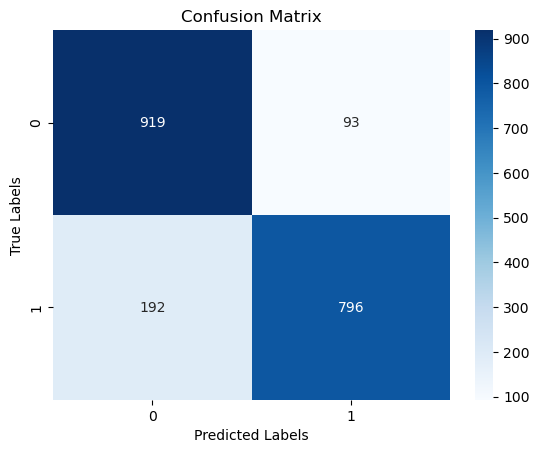

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [67]:
import joblib
joblib.dump(svm, 'SVM_S_Linear_En_Ar_MModel.pkl')

import pickle
filename = 'SVM_S_Linear_En_Ar_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_S_Linear_En_Ar_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [68]:

svm = joblib.load('SVM_S_Linear_En_Ar_MModel.pkl')

In [69]:

# determine the minimum number of rows for each rating value
min_count = df2["rating"].value_counts().min()
min_count = 2500
# subset the original dataset for each rating value
df_1 = df2[df2["rating"] == 1]
df_2 = df2[df2["rating"] == 2]
df_4 = df2[df2["rating"] == 4]
df_5 = df2[df2["rating"] == 5]

# randomly sample the minimum number of rows for each rating value
df_1_sampled = df_1.sample(n=min_count, random_state=42)
df_2_sampled = df_2.sample(n=min_count, random_state=42)
df_4_sampled = df_4.sample(n=min_count, random_state=42)
df_5_sampled = df_5.sample(n=min_count, random_state=42)

# combine the sampled rows for each rating value into a new dataset
df_balanced = pd.concat([df_1_sampled, df_2_sampled, df_4_sampled, df_5_sampled])

# save the balanced dataset to a new file
df_balanced.to_csv("balanced_dataset.csv", index=False)

df = pd.read_csv('balanced_dataset.csv')
# Define a function to map the rating to sentiment
def map_sentiment(rating):
    if rating in [1, 2]:
        return "negative"
    elif rating in [4, 5]:
        return "positive"
    else:
        raise ValueError("Invalid rating value: {}".format(rating))

# Apply the function to the 'rating' column and create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Apply sentence embeddings to first column of dataframe
reviews = df['review'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, ar_embeddings, "ar")

# Add new column with embeddings to dataframe
df['arabic_Embeddings'] = reviews_embeddings

X_test = np.vstack(df['arabic_Embeddings']) 
y_test = df['sentiment']
y_pred = svm.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.8649
              precision    recall  f1-score   support

    negative       0.84      0.91      0.87      5000
    positive       0.90      0.82      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



[[4532  468]
 [ 883 4117]]


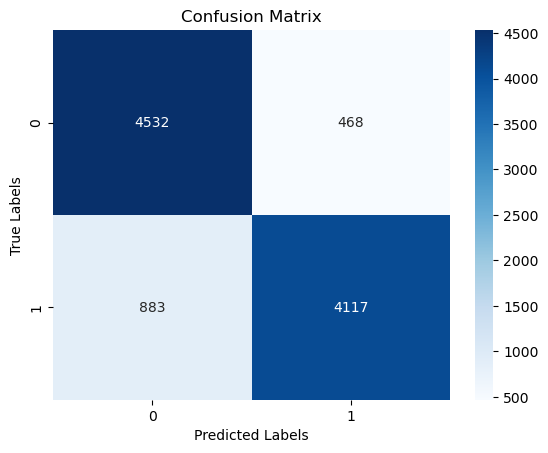

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# French - FineTune - Test

In [71]:
svm = joblib.load('SVM_S_Linear_En_Ar_MModel.pkl')
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample = sample.head(500)

# Apply sentence embeddings to first column of dataframe
reviews = final_sample['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample['french_Embeddings'] = reviews_embeddings

X_test = np.vstack(final_sample['french_Embeddings']) 
y_test = final_sample['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, binary_y_pred)
report = classification_report(y_test, binary_y_pred)
print("Accuracy:", accuracy)
print(report)

C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\3020337611.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample['french_Embeddings'] = reviews_embeddings


Accuracy: 0.566
              precision    recall  f1-score   support

           0       0.55      0.79      0.64       250
           1       0.62      0.34      0.44       250

    accuracy                           0.57       500
   macro avg       0.58      0.57      0.54       500
weighted avg       0.58      0.57      0.54       500



[[197  53]
 [164  86]]


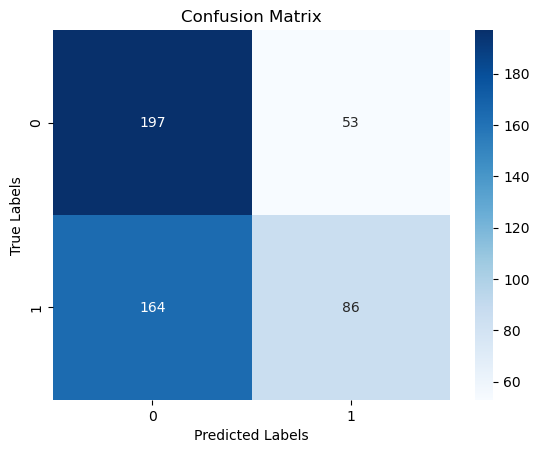

In [72]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, binary_y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [73]:
import pandas as pd

# Load the entire dataset into a DataFrame
df = pd.read_csv('C:/Users/ALI/Desktop/French Dataset/french_tweets.csv')

# Split the dataset into two separate DataFrames by class
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_1 = sample.head(500)


# Sample 250 rows from each class
sample_0 = class_0.sample(n=250, random_state=42)
sample_1 = class_1.sample(n=250, random_state=42)

# Combine the two samples into a single DataFrame
sample = pd.concat([sample_0, sample_1])


# Shuffle the rows of the combined sample
sample = sample.sample(frac=1, random_state=42)

# Take the first 500 rows of the shuffled sample
final_sample_2 = sample.head(500)
# Apply sentence embeddings to first column of dataframe
reviews = final_sample_1['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_1['french_Embeddings'] = reviews_embeddings

# Apply sentence embeddings to first column of dataframe
reviews = final_sample_2['text'].tolist()
reviews_embeddings = compute_sentence_embeddings(reviews, fr_embeddings, "fr")

# Add new column with embeddings to dataframe
final_sample_2['french_Embeddings'] = reviews_embeddings
import pandas as pd
from sklearn.model_selection import train_test_split



X = np.vstack(final_sample_1['french_Embeddings']) 
y = final_sample_1['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm.fit(X_train, y_train)

# Evaluate the performance of the SVM on the testing set
y_pred = svm.predict(X_test)
# from sklearn.preprocessing import LabelEncoder
# # create a LabelEncoder object
# le = LabelEncoder()

# # fit the encoder to the values and transform the values to binary values
# binary_y_pred = le.fit_transform(y_pred)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        43
           1       0.90      0.46      0.60        57

    accuracy                           0.66       100
   macro avg       0.73      0.69      0.65       100
weighted avg       0.75      0.66      0.65       100



C:\Users\ALI\AppData\Local\Temp\ipykernel_5976\2146145837.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_sample_2['french_Embeddings'] = reviews_embeddings


[[40  3]
 [31 26]]


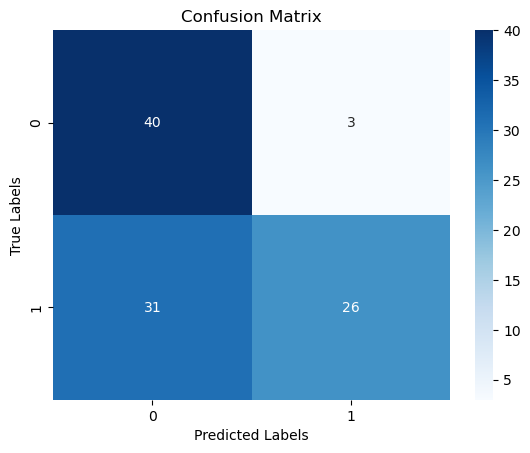

In [74]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [75]:
import joblib
joblib.dump(svm, 'SVM_S_Linear_En_Ar_Fr_MModel.pkl')

import pickle
filename = 'SVM_S_Linear_En_Ar_Fr_MModel.sav'
pickle.dump(svm, open(filename, 'wb'))

svm = joblib.load('SVM_S_Linear_En_Ar_Fr_MModel.pkl')
svm = pickle.load(open(filename, 'rb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [76]:

svm = joblib.load('SVM_S_Linear_En_Ar_Fr_MModel.pkl')

In [77]:
X_test = np.vstack(final_sample_2['french_Embeddings']) 
y_test = final_sample_2['label']
y_pred = svm.predict(X_test)
from sklearn.preprocessing import LabelEncoder
# create a LabelEncoder object
le = LabelEncoder()

# fit the encoder to the values and transform the values to binary values
binary_y_pred = le.fit_transform(y_pred)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Accuracy: 0.678
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       250
           1       0.79      0.48      0.60       250

    accuracy                           0.68       500
   macro avg       0.71      0.68      0.67       500
weighted avg       0.71      0.68      0.67       500



[[218  32]
 [129 121]]


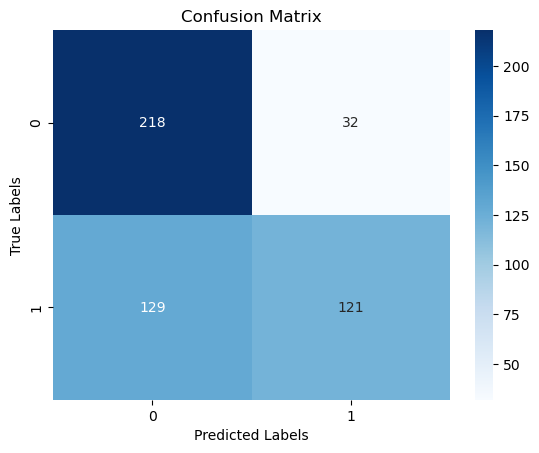

In [78]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print(cm)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()